## **Effects of alcohol on student performance**
### Data Analytics
### Automatic Control and Robotic, Cyber-physical Systems
#### **Daniel Jurkowski (407200) & Adam Pękala (405380)**



##### Modules import

In [53]:
from cmdstanpy import CmdStanModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import arviz as az
import seaborn as sns
import cmdstanpy


##### CmdStanPy installation

In [54]:
cmdstanpy.install_cmdstan()

CmdStan install directory: /home/kosolic/.cmdstan
CmdStan version 2.34.1 already installed
Test model compilation


True

##### 1. Problem formulation

Alcohol use among students is a topic of interest due to its potential impact on educational outcomes. This project aims to explore the relationship between alcohol consumption and student grades (GPA - Grade Point Average), with a focus on predicting academic performance based on alcohol consumption patterns. We will create statistical models to analyze how alcohol use influences students’ achievements. Understanding these effects can inform educational institutions and policymakers in promoting healthier behaviors among students.

The data used for this project comes from an anonymous survey comprising sixteen questions meticulously crafted and distributed across diverse student chat forums at Stellenbosch University in South Africa in 2023. The author, from the Department of Statistics and Actuarial Science, focused on collecting information about gender, grade point average, faculty studied at, hours spent studying, personal life situations, and socializing habits related to alcohol use.


|                                          **Column name**                                          |                                                       **Description**                                                      |
|:-------------------------------------------------------------------------------------------------:|:--------------------------------------------------------------------------------------------------------------------------:|
| Your Sex?                                                                                         | The sex of the student                                                                                                     |
| Your Matric (grade 12) Average/ GPA (in %)                                                        | The students academic average (GPA) achieved in Matric (Year 12)                                                           |
| What year were you in last year (2023) ?                                                          | Current academic year at Stellenbosch University                                                                           |
| What faculty does your degree fall under?                                                         | The academic department to which the student's degree program belongs                                                      |
| Your 2023 academic year average/GPA in % (Ignore if you are 2024 1st year student)                | The academic average of the student for their prior year of studies at Stellenbosch University                             |
| Your Accommodation Status Last Year (2023)                                                        | The student's accommodation status, which may include either private lodging or non-private/university-provided housing    |
| Monthly Allowance in 2023                                                                         | The budgetary range within the student's monthly allowance are situated                                                    |
| Were you on scholarship/bursary in 2023?                                                          | Wheter the student is enrolled in scholarship or funding program                                                           |
| Additional amount of studying (in hrs) per week                                                   | The number of additional hours student work beyond their standard class schedule                                           |
| How often do you go out partying/socialising during the week?                                     | The frequency with which a student engages in social activities, whether during weekdays or weekends                       |
| On a night out, how many alcoholic drinks do you consume?                                         | The quantity of alcoholic beverages consumed by the student during socialising                                             |
| How many classes do you miss per week due to alcohol reasons, (i.e: being hungover or too tired?) | The count of classes missed by the student during the week due to alcohol-related reasons, such as experiencing a hangover |
| How many modules have you failed thus far into your studies?                                      | The total count of modules failed by the student thus far in their academic journey at Stellenbosch University             |
| Are you currently in a romantic relationship?                                                     | Whether the student is currently involved in a romantic relationship or not                                                |
| Do your parents approve alcohol consumption?                                                      | Whether the student has obtained parental approval for alcohol consumption or not                                          |
| How strong is your relationship with your parent/s?                                               | The level of strength or closeness in the student's relationship with their parents  

### 1.1 TODO: DAG diagram 

### 1.2 TODO: Confoundings 

##### 1.3 Data exploring

In [55]:
raw_data = pd.read_csv("data/survey.csv")
raw_data.head()

,Timestamp,Your Sex?,Your Matric (grade 12) Average/ GPA (in %),What year were you in last year (2023) ?,What faculty does your degree fall under?,Your 2023 academic year average/GPA in % (Ignore if you are 2024 1st year student),Your Accommodation Status Last Year (2023),Monthly Allowance in 2023,Were you on scholarship/bursary in 2023?,Additional amount of studying (in hrs) per week,How often do you go out partying/socialising during the week?,"On a night out, how many alcoholic drinks do you consume?","How many classes do you miss per week due to alcohol reasons, (i.e: being hungover or too tired?)",How many modules have you failed thus far into your studies?,Are you currently in a romantic relationship?,Do your parents approve alcohol consumption?,How strong is your relationship with your parent/s?
0,2024/03/07 5:12:01 pm EET,Female,76.0,2nd Year,Arts & Social Sciences,72.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,8+,Only weekends,8+,3,0,Yes,Yes,Very close
1,2024/03/07 5:12:08 pm EET,Male,89.0,2nd Year,Economic & Management Sciences,75.0,Private accommodation/ stay with family/friends,R 7001 - R 8000,"Yes (NSFAS, etc...)",8+,Only weekends,3-5,4+,0,No,Yes,Very close
2,2024/03/07 5:12:25 pm EET,Male,76.0,1st Year,AgriSciences,55.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,2,8+,3,0,No,Yes,Very close
3,2024/03/07 5:12:28 pm EET,Male,89.0,2nd Year,Engineering,84.0,Private accommodation/ stay with family/friends,R 6001 - R 7000,No,3-5,3,8+,2,0,Yes,Yes,Very close
4,2024/03/07 5:13:00 pm EET,Female,74.0,2nd Year,Arts & Social Sciences,52.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,Only weekends,5-8,1,3,No,Yes,Fair


In [56]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   Timestamp                                                                                          406 non-null    object 
 1   Your Sex?                                                                                          404 non-null    object 
 2   Your Matric (grade 12) Average/ GPA (in %)                                                         399 non-null    float64
 3   What year were you in last year (2023) ?                                                           333 non-null    object 
 4   What faculty does your degree fall under?                                                          399 non-null    object 

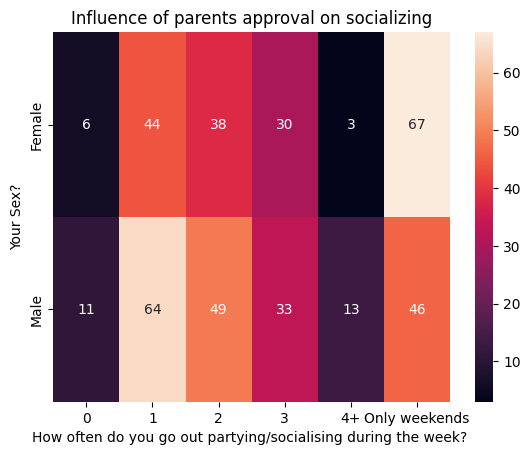

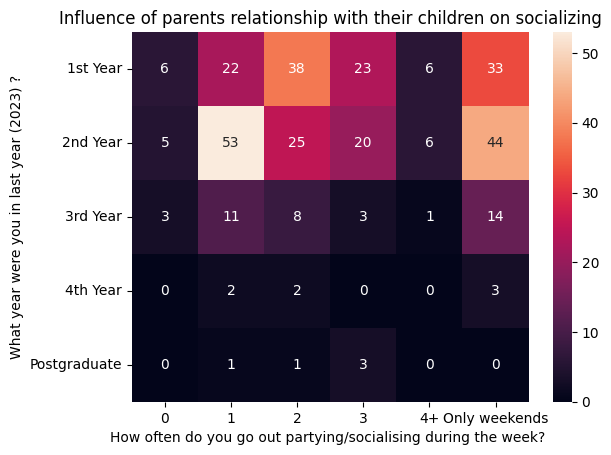

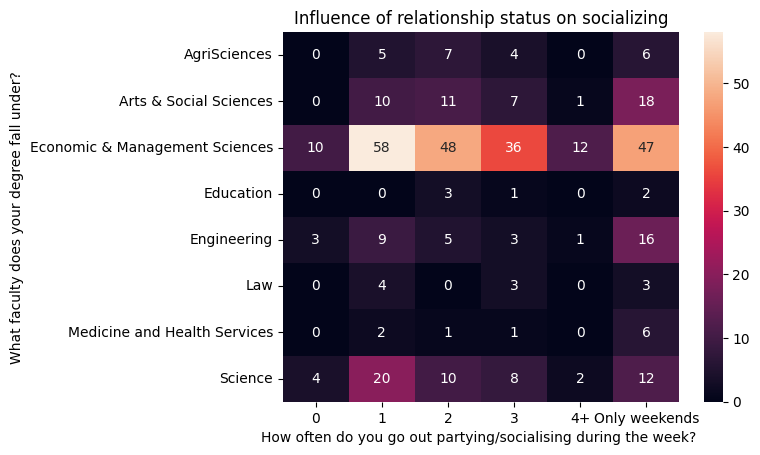

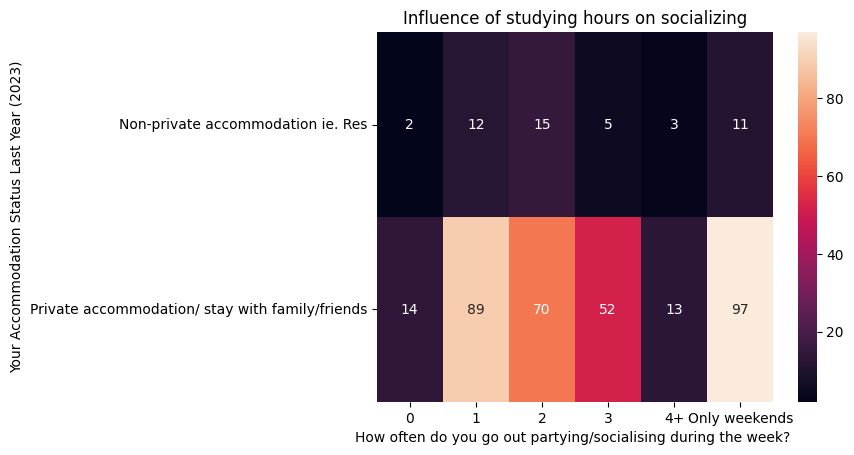

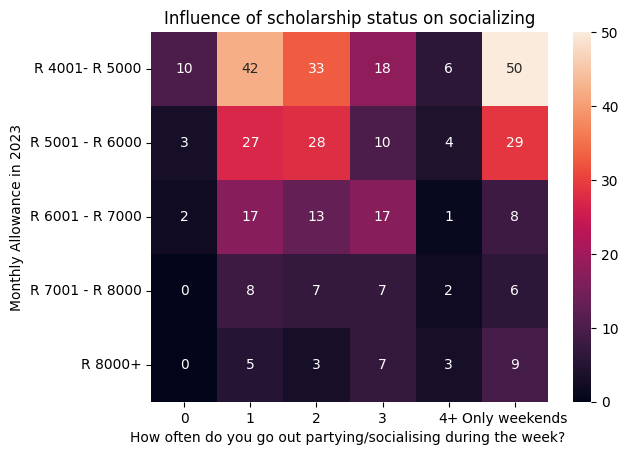

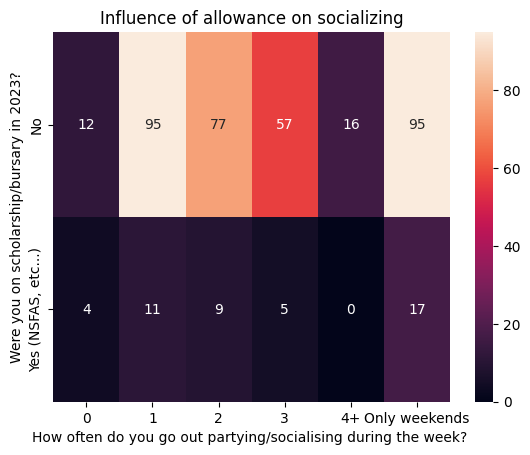

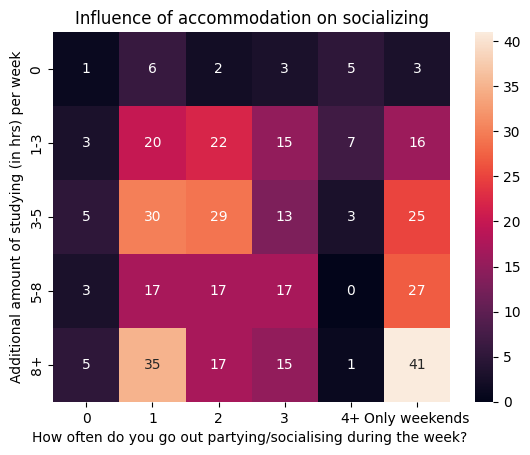

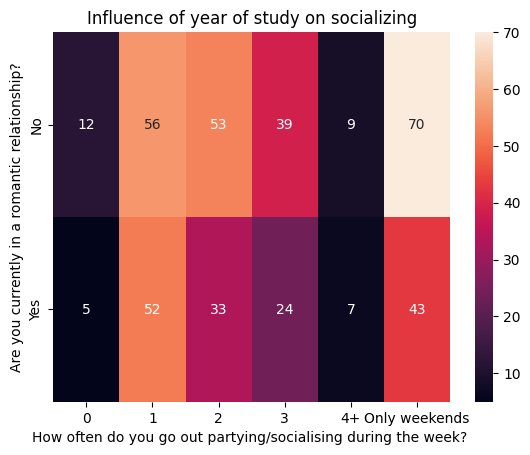

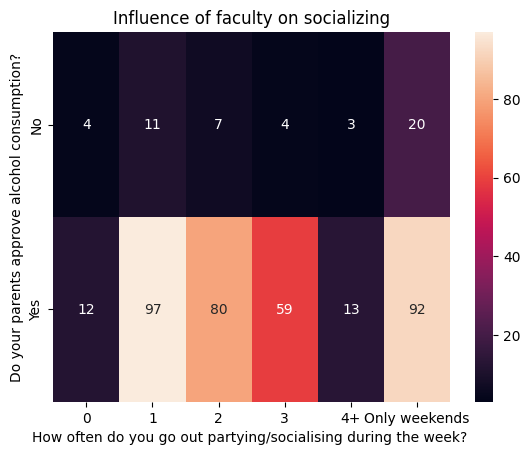

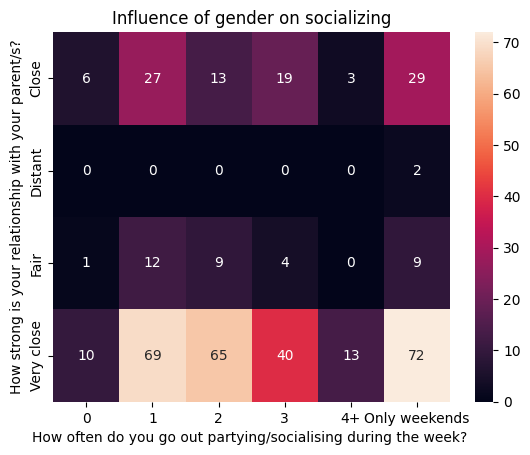

In [57]:
selected_columns = [1, 3, 4, 6, 7, 8, 9, 14, 15, 16]
initials = ['parents approval', 'parents relationship with their children',
           'relationship status', 'studying hours', 'scholarship status', 'allowance',
           'accommodation', 'year of study', 'faculty', 'gender']


for i, j in enumerate(selected_columns):    
    cross = pd.crosstab(raw_data[raw_data.columns[j]], raw_data[raw_data.columns[10]])
    sns.heatmap(cross, annot=True)
    plt.title(f'Influence of {initials[i]} on socializing')
    plt.show()

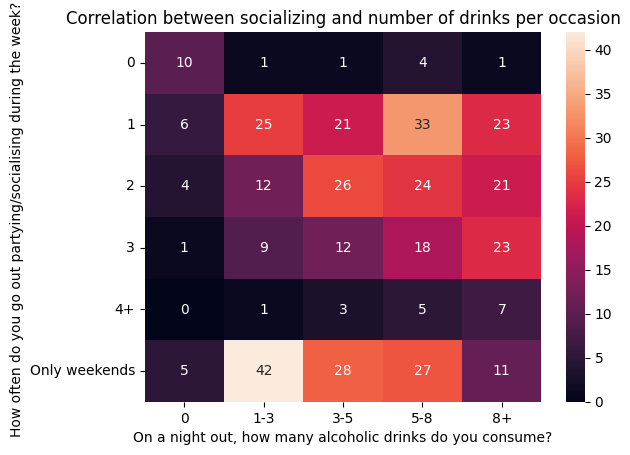

In [58]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[10]], raw_data[raw_data.columns[11]]), annot=True)
plt.title('Correlation between socializing and number of drinks per occasion')
plt.show()

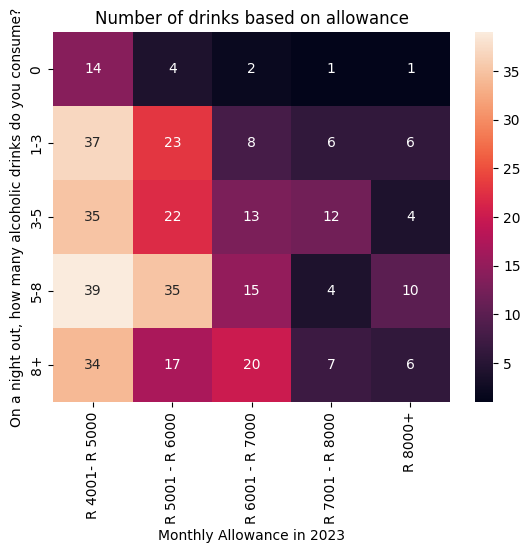

In [59]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[11]], raw_data[raw_data.columns[7]]), annot=True)
plt.title('Number of drinks based on allowance')
plt.show()

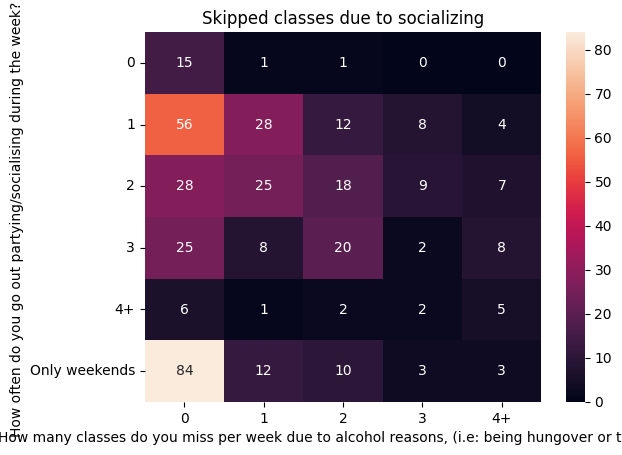

In [60]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[10]], raw_data[raw_data.columns[12]]), annot=True)
plt.title('Skipped classes due to socializing')
plt.show()

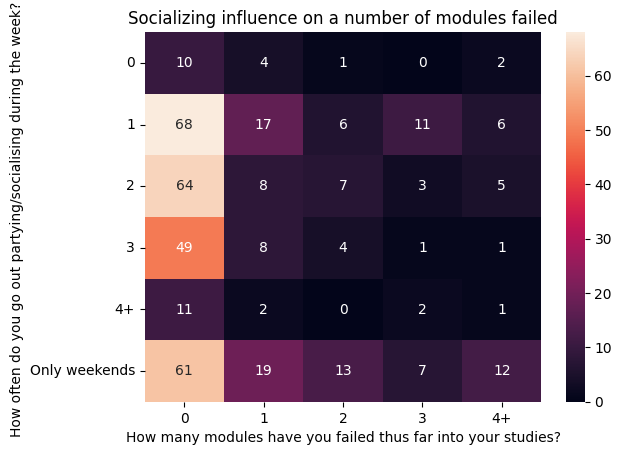

In [61]:
sns.heatmap(pd.crosstab(raw_data[raw_data.columns[10]], raw_data[raw_data.columns[13]]), annot=True)
plt.title('Socializing influence on a number of modules failed')
plt.show()

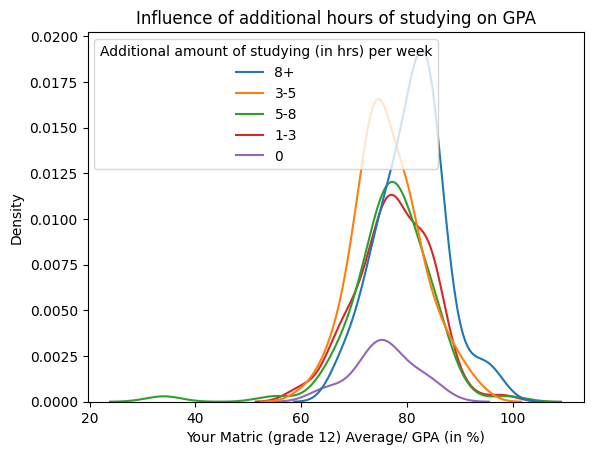

In [62]:
sns.kdeplot(raw_data, x=raw_data.columns[2], hue=raw_data.columns[9])
plt.title('Influence of additional hours of studying on GPA')
plt.show()

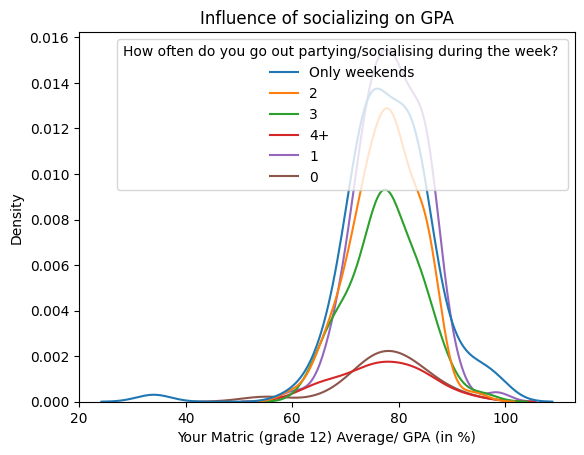

In [63]:
sns.kdeplot(raw_data, x=raw_data.columns[2], hue=raw_data.columns[10])
plt.title('Influence of socializing on GPA')
plt.show()

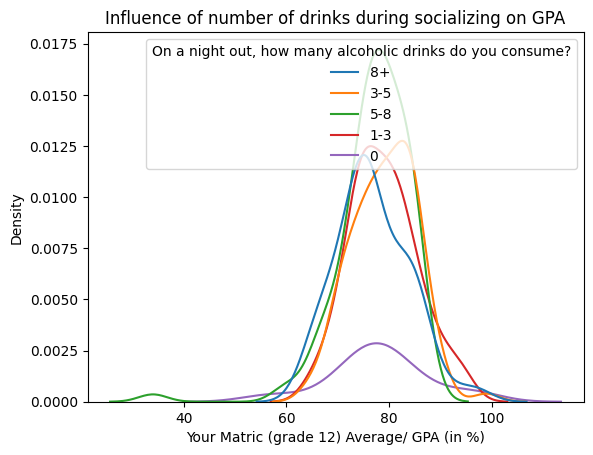

In [64]:
sns.kdeplot(raw_data, x=raw_data.columns[2], hue=raw_data.columns[11])
plt.title('Influence of number of drinks during socializing on GPA')
plt.show()

### TODO: Some thoughts about presented plots

##### 2. Data preprocessing
* Timestamp column will be dropped as it doesn't give any useful information for our purposes.
* To work with the gathered data, we’ll simplify column names for easier reference. This practice improves readability and reduces typing effort.
* Rows containing NaN or missing values will be dropped. This ensures that our dataset remains clean and accurate.
* Values described by two options (e.g., “yes” and “no”), will be converted  to binary format ("0" or "1"). This simplifies the representation.
* Values describing incremental features (e.g., “very close,” “close,” “fair,” “distant”) will be mapped to numerical values ("3", "2", "1", "0"). Same thing will be applied to values with range format.
* The value “Only weekends” describing social activities will be changed to “2” for simplification, even though it differs from the actual value “2” (which represents drinking on weekdays, because it can have less influence on academic performance).
* Faculties will be ranked subjectively from easiest to hardest for passing.

In [65]:
data = raw_data.copy()

# Rename columns and drop timestamp column
columns_names = {
    data.columns[1]: "Gender",
    data.columns[2]: "Current GPA",
    data.columns[3]: "Year",
    data.columns[4]: "Faculty",
    data.columns[5]: "Prior GPA",
    data.columns[6]: "Accommodation",
    data.columns[7]: "Allowance",
    data.columns[8]: "Scholarship",
    data.columns[9]: "Studying hours",
    data.columns[10]: "Hangouts",
    data.columns[11]: "Drinks",
    data.columns[12]: "Missed classes",
    data.columns[13]: "Failed modules",
    data.columns[14]: "Relationship",
    data.columns[15]: "Parents approvement",
    data.columns[16]: "Relationship with parents",}

data.rename(columns = columns_names, inplace=True)
data = data.drop('Timestamp', axis=1)
data.head()

,Gender,Current GPA,Year,Faculty,Prior GPA,Accommodation,Allowance,Scholarship,Studying hours,Hangouts,Drinks,Missed classes,Failed modules,Relationship,Parents approvement,Relationship with parents
0,Female,76.0,2nd Year,Arts & Social Sciences,72.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,8+,Only weekends,8+,3,0,Yes,Yes,Very close
1,Male,89.0,2nd Year,Economic & Management Sciences,75.0,Private accommodation/ stay with family/friends,R 7001 - R 8000,"Yes (NSFAS, etc...)",8+,Only weekends,3-5,4+,0,No,Yes,Very close
2,Male,76.0,1st Year,AgriSciences,55.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,2,8+,3,0,No,Yes,Very close
3,Male,89.0,2nd Year,Engineering,84.0,Private accommodation/ stay with family/friends,R 6001 - R 7000,No,3-5,3,8+,2,0,Yes,Yes,Very close
4,Female,74.0,2nd Year,Arts & Social Sciences,52.0,Private accommodation/ stay with family/friends,R 4001- R 5000,No,3-5,Only weekends,5-8,1,3,No,Yes,Fair


In [66]:
# Check data for unique values, and check if NaN or missing values are present
for column in data:
    print(data[column].unique())

['Female' 'Male' nan]
[76.   89.   74.   83.   80.   85.   75.   79.   72.   78.   87.   86.
 69.   73.   84.   99.   82.6  65.   81.   88.   70.   98.   90.   98.33
   nan 82.   77.   68.   66.   92.   91.86 71.   63.   67.   60.   94.
 95.   34.   86.4  95.5  55.   91.21 96.   64.  ]
['2nd Year' '1st Year' nan '3rd Year' '4th Year' 'Postgraduate']
['Arts & Social Sciences' 'Economic & Management Sciences' 'AgriSciences'
 'Engineering' 'Science' 'Medicine and Health Services' 'Law' 'Education'
 nan]
[72.   75.   55.   84.   52.     nan 54.   64.   76.   65.   62.   69.
 60.   74.   70.   63.   73.   57.   90.   78.   61.   89.   80.   66.
 58.   95.22 71.   53.   50.   88.   79.   56.   51.   68.   77.   65.89
 73.5  59.   67.   92.   87.6  83.   30.   81.   69.7  85.  ]
['Private accommodation/ stay with family/friends' nan
 'Non-private accommodation ie. Res']
['R 4001- R 5000' 'R 7001 - R 8000' 'R 6001 - R 7000' 'R 5001 - R 6000'
 nan 'R 8000+']
['No' 'Yes (NSFAS, etc...)' nan]
['8

In [67]:
# Drop rows with NaN (missing) values, use mapping to change values to more readable format
data.dropna(axis=0, how='any', inplace=True)

gender_map = {
    'Female': 1,
    'Male': 0
}

year_map = {
    '1st Year': 0,
    '2nd Year': 1,
    '3rd Year': 2,
    '4th Year': 3,
    'Postgraduate': 4
}

faculty_map = {
    'AgriSciences': 0,
    'Arts & Social Sciences': 1,
    'Education': 2,
    'Economic & Management Sciences': 3,
    'Medicine and Health Services': 4,
    'Science': 5,
    'Engineering': 6,
    'Law': 7
}

accommodation_map = {
    'Private accommodation/ stay with family/friends': 1,
    'Non-private accommodation ie. Res': 0
}

allowance_map = {
    'R 4001- R 5000': 0,
    'R 5001 - R 6000': 1,
    'R 6001 - R 7000': 2,
    'R 7001 - R 8000': 3,
    'R 8000+': 4,
}

scholarship_map = {
    'Yes (NSFAS, etc...)' : 1,
    'No' : 0
}

study_hours_map = {
    '0': 0,
    '1-3': 1,
    '3-5': 2,
    '5-8': 3,
    '8+': 4
}

hangouts_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4,
    'Only weekends' : 2
}

drinks_map = {
    '0': 0,
    '1-3': 1,
    '3-5': 2,
    '5-8': 3,
    '8+': 4
}

missed_classes_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4
}

failed_modules_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4
}

relationship_map = {
    'Yes' : 1,
    'No' : 0
}

parents_approvement_map = {
    'Yes' : 1,
    'No' : 0
}

parents_relationship_map = {
    'Distant' : 0,
    'Fair' : 1,
    'Close' : 2,
    'Very close' : 3
}

maps = {
    'Gender': gender_map,
    'Year': year_map,
    'Faculty': faculty_map,
    'Accommodation': accommodation_map,
    'Allowance': allowance_map,
    'Scholarship': scholarship_map,
    'Studying hours': study_hours_map,
    'Hangouts': hangouts_map,
    'Drinks': drinks_map,
    'Missed classes': missed_classes_map,
    'Failed modules': failed_modules_map,
    'Relationship': relationship_map,
    'Parents approvement': parents_approvement_map,
    'Relationship with parents': parents_relationship_map
}

for column in data:
    if column not in ['Current GPA', 'Prior GPA']:
        data[column] = data[column].map(lambda x: maps[column].get(x, x))
        
data.head()

,Gender,Current GPA,Year,Faculty,Prior GPA,Accommodation,Allowance,Scholarship,Studying hours,Hangouts,Drinks,Missed classes,Failed modules,Relationship,Parents approvement,Relationship with parents
0,1,76.0,1,1,72.0,1,0,0,4,2,4,3,0,1,1,3
1,0,89.0,1,3,75.0,1,3,1,4,2,2,4,0,0,1,3
2,0,76.0,0,0,55.0,1,0,0,2,2,4,3,0,0,1,3
3,0,89.0,1,6,84.0,1,2,0,2,3,4,2,0,1,1,3
4,1,74.0,1,1,52.0,1,0,0,2,2,3,1,3,0,1,1


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295 entries, 0 to 402
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     295 non-null    int64  
 1   Current GPA                295 non-null    float64
 2   Year                       295 non-null    int64  
 3   Faculty                    295 non-null    int64  
 4   Prior GPA                  295 non-null    float64
 5   Accommodation              295 non-null    int64  
 6   Allowance                  295 non-null    int64  
 7   Scholarship                295 non-null    int64  
 8   Studying hours             295 non-null    int64  
 9   Hangouts                   295 non-null    int64  
 10  Drinks                     295 non-null    int64  
 11  Missed classes             295 non-null    int64  
 12  Failed modules             295 non-null    int64  
 13  Relationship               295 non-null    int64  
 14 

In [69]:
for column in data:
    print(data[column].unique())

[1 0]
[76.   89.   74.   80.   85.   79.   72.   87.   69.   83.   78.   84.
 86.   73.   99.   82.6  65.   81.   88.   75.   98.   90.   98.33 70.
 82.   77.   68.   92.   71.   63.   67.   95.   86.4  60.   95.5  94.
 66.   64.  ]
[1 0 2 3 4]
[1 3 0 6 5 7 4 2]
[72.   75.   55.   84.   52.   54.   64.   76.   65.   62.   69.   60.
 74.   70.   63.   73.   57.   90.   78.   61.   89.   80.   66.   58.
 95.22 71.   53.   88.   79.   56.   51.   68.   50.   77.   73.5  59.
 67.   92.   87.6  83.   30.   81.   69.7  85.  ]
[1 0]
[0 3 2 1 4]
[0 1]
[4 2 1 3 0]
[2 3 1 4 0]
[4 2 3 1 0]
[3 4 2 1 0]
[0 3 4 1 2]
[1 0]
[1 0]
[3 1 2 0]


In [70]:
data.to_csv('data/survey_cleaned.csv', index=False, sep=',')

## 3. Model ##

In order to compare the results generated by the models, the average GPA value from the available data was calculated, the number of records was counted, and their distribution was presented.

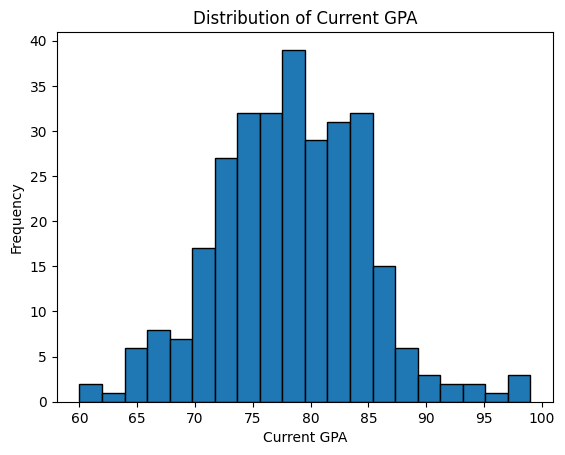

Number of rows in column: 295
Mean value of Current GPA:  78.20959322033899


In [71]:
plt.hist(data['Current GPA'], bins=20, edgecolor='black')

plt.xlabel('Current GPA')
plt.ylabel('Frequency')
plt.title('Distribution of Current GPA')
plt.show()
row_count = data[column].count()
print("Number of rows in column:", row_count)

average_current_gpa = data['Current GPA'].mean()
print("Mean value of Current GPA: ", average_current_gpa)

## 4. Priors ##
The distributions in the Stan code are chosen based on common statistical assumptions about the nature of the data and the factors influencing GPA (Grade Point Average). Here’s why each distribution was selected:

### Model 1 prior

### Normal Distribution for Studying Hours:
The normal distribution is chosen for studying_hours because it’s a common assumption that such continuous variables are normally distributed in a population. The mean of 7 and standard deviation of 3 suggest that most students study around 7 hours.
### Uniform Distribution for Hangouts: 
The uniform distribution is used for hangouts to model the number of times students go out in a week. This assumes that all values in the range from 0 to 4 are equally likely, reflecting no prior knowledge favoring one number of hangouts over another.

### Normal Distribution for Predicted GPA: 
The predicted GPA is generated using a normal distribution where the mean is a linear combination of studying_hours, hangouts,  along with a constant value to shift the mean towards the typical GPA range. A smaller sigma value is used to ensure that the generated GPAs are densely packed around the mean, reflecting the expectation that most GPAs will be close to the average with some variation.

The absolute value is used when generating sigma to ensure that the standard deviation is positive, as the standard deviation cannot be negative.
The constants used in the linear combination (1.5 for studying hours and -1 for hangouts) are likely based on the assumption that more studying hours positively affect GPA, while more hangouts negatively affect it. The constant value of 70 is added to shift the mean of the GPA distribution towards the typical range of 70-80%.

### Generating samples
The number of iterations was chosen based on the number of records in the data.


In [72]:
model1_prior=CmdStanModel(stan_file='model_prior_1.stan')

R = 295
data_simulated = {'N': 10}  
samples_model1 = model1_prior.sample(data=data_simulated,
                                     iter_sampling=R,
                                     iter_warmup=1,
                                     chains=1,
                                     fixed_param=True,
                                     seed=20052024,
                                     refresh=R)


22:56:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

22:56:51 - cmdstanpy - INFO - CmdStan done processing.


In [73]:
df = samples_model1.draws_pd()

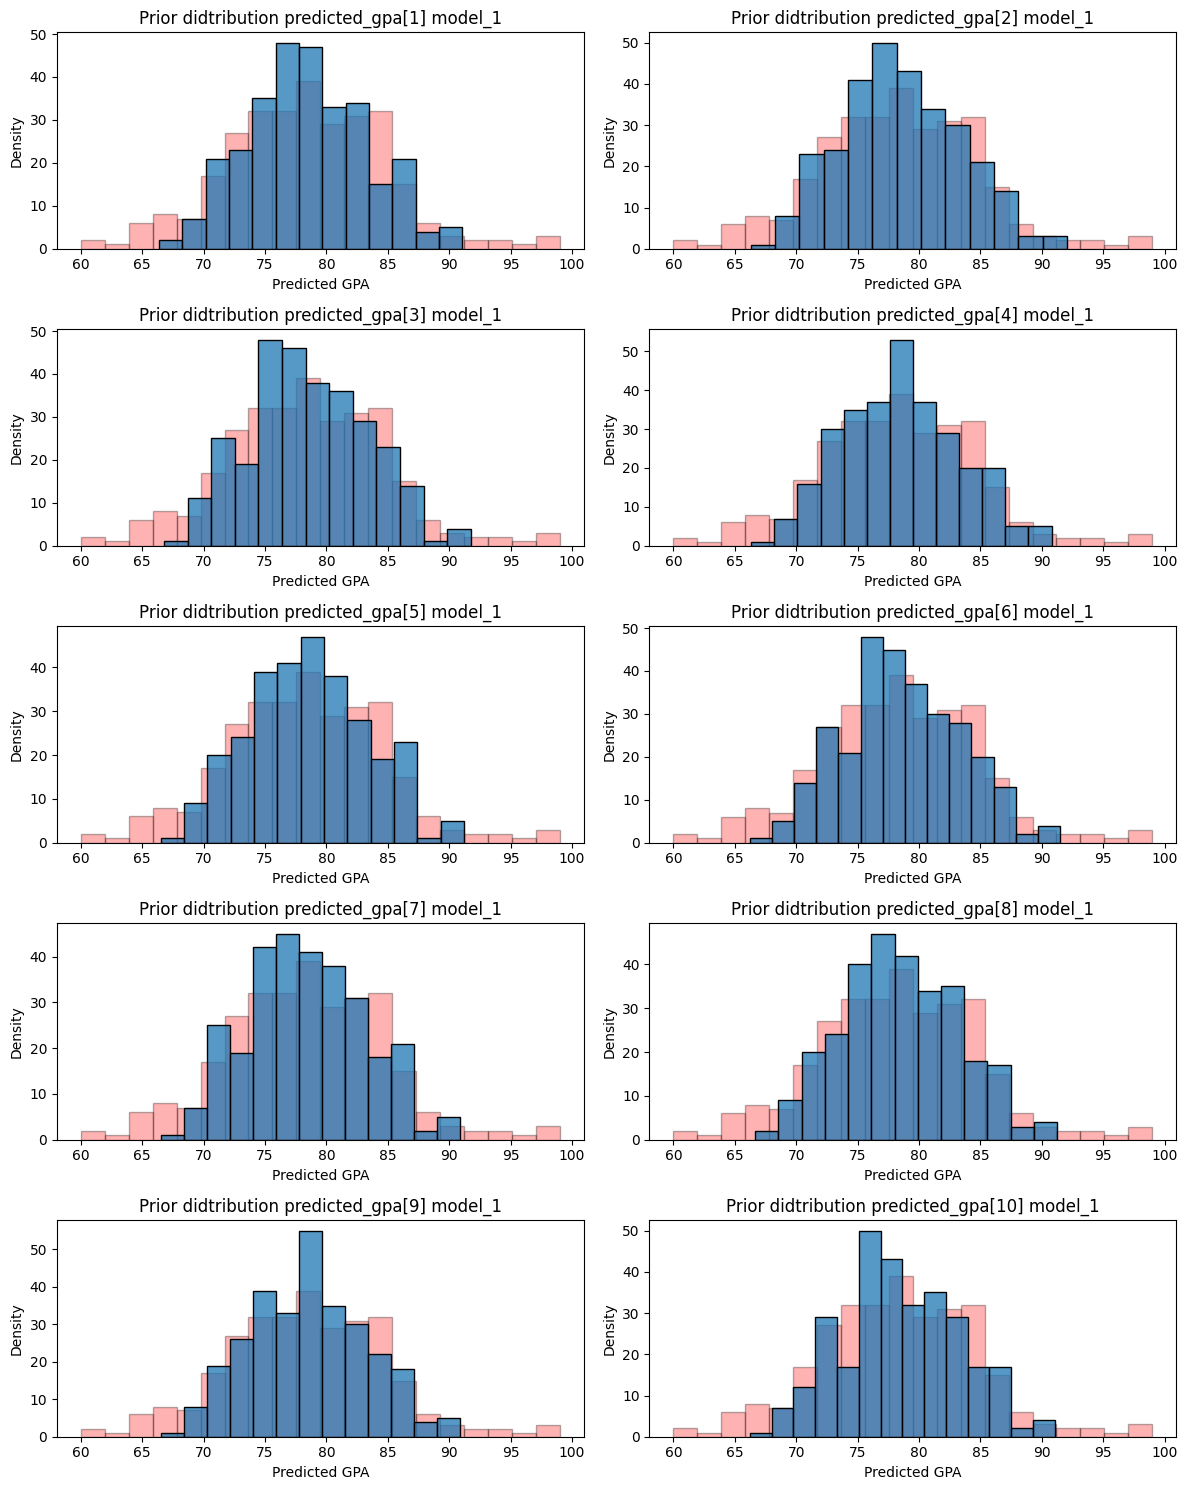

In [74]:
columns = [f'predicted_gpa[{i+1}]' for i in range(10)]

num_rows = 5
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 15))

for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    ax.hist(data['Current GPA'], bins=20,color='red', edgecolor='black', alpha=0.3)
    
    sns.histplot(df[column], ax=ax)
    
    ax.set_title(f'Prior didtribution {column} model_1')
    ax.set_xlabel('Predicted GPA')
    ax.set_ylabel('Density')

# Remove empty subplots if any
if len(columns) < num_rows * num_cols:
    for i in range(len(columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### Model 2 prior

### In second model Gamma distribution was chosen due to the several factors:

- Lower Bound Limitation: The gamma distribution is a continuous distribution that takes on positive values. This is suitable for GPA, as grades are always non-negative.

- Asymmetry: The gamma distribution can take on various shapes, including asymmetric ones, which is useful when we expect that the data distribution is not symmetrical. For example, most students may have grades clustered around a certain value with fewer students achieving very high or very low results.

- Flexibility: The alpha (shape) and beta (scale) parameters in the gamma distribution allow for great flexibility in modeling different types of data. They can be adjusted to reflect the expected mean values and variability of the data.
The values of alpha and beta were chosen so that the mean of the gamma distribution was close to the expected GPA mean, which is around 70-80. The alpha parameter determines the shape of the distribution, and beta the scale. 

    - Alpha = 11: This value was chosen to make the distribution shape appropriate for GPA data. A larger alpha value can cause the distribution to be more concentrated around the mean, which is desirable when most students have grades in a similar range.

    - Beta = 0.15: This parameter determines the scale of the distribution. The beta value was chosen so that the mean of the distribution was close to the expected GPA range. In this case, a smaller beta value causes the distribution to be wider, allowing for greater variability in grades.

In [75]:
model2_prior=CmdStanModel(stan_file='model_prior_2.stan')

R = 295
data_simulated = {'N': 10}  
samples_model2 = model1_prior.sample(data=data_simulated,
                                     iter_sampling=R,
                                     iter_warmup=1,
                                     chains=1,
                                     fixed_param=True,
                                     seed=20052024,
                                     refresh=R)

22:56:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

22:56:52 - cmdstanpy - INFO - CmdStan done processing.


In [76]:
df_2 = samples_model2.draws_pd()

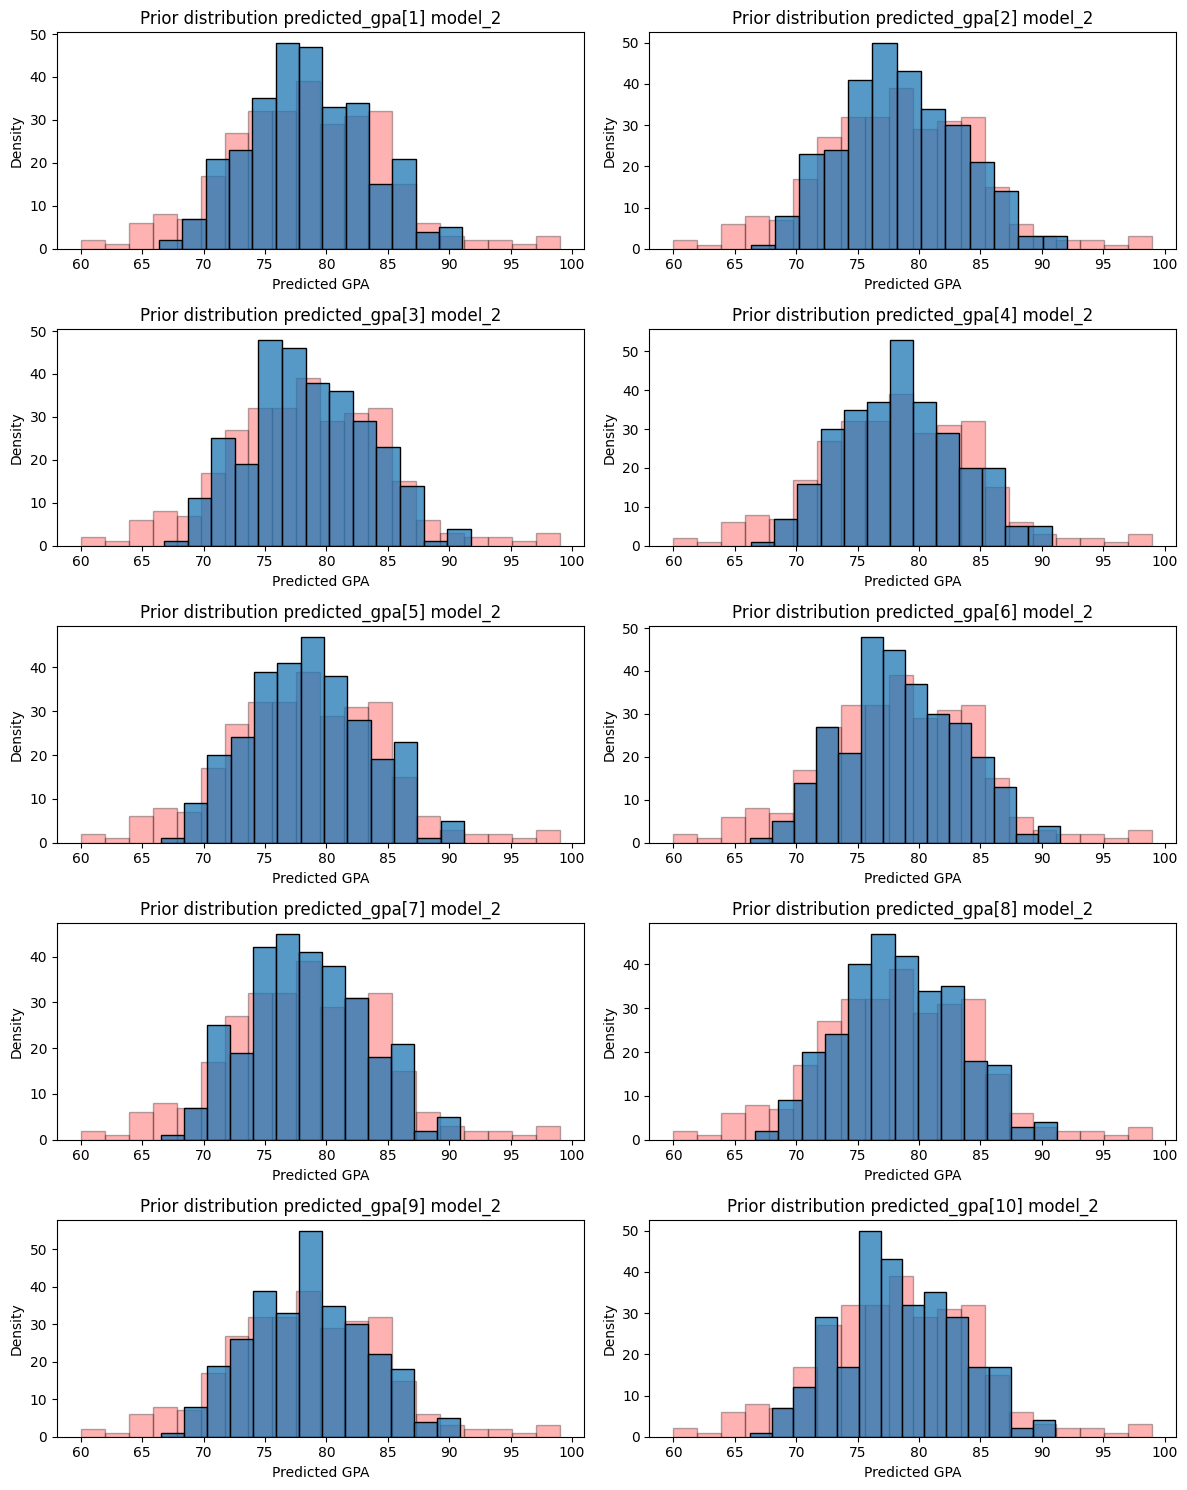

In [77]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 15))

for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    ax.hist(data['Current GPA'], bins=20,color='red', edgecolor='black', alpha=0.3)
    
    sns.histplot(df_2[column], ax=ax)
    
    ax.set_title(f'Prior distribution {column} model_2')
    ax.set_xlabel('Predicted GPA')
    ax.set_ylabel('Density')

# Remove empty subplots if any
if len(columns) < num_rows * num_cols:
    for i in range(len(columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

## 5. Posterior analysis for first model
Description

## 6. Posterior analysis for second model
Description

## 7. Model comparison
Description

## 8. Summary
Description